Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Load dataset (adjust path accordingly)
raw = pd.read_csv('data/raw/Star99999_raw.csv')

# Display initial info
print("Initial Dataset Info:")
raw.info()

# Display first few rows
raw.head()


Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  99999 non-null  int64 
 1   Vmag        99999 non-null  object
 2   Plx         99999 non-null  object
 3   e_Plx       99999 non-null  object
 4   B-V         99999 non-null  object
 5   SpType      97377 non-null  object
dtypes: int64(1), object(5)
memory usage: 4.6+ MB


,Unnamed: 0,Vmag,Plx,e_Plx,B-V,SpType
0,0,9.10,3.54,1.39,0.482,F5
1,1,9.27,21.90,3.10,0.999,K3V
2,2,6.61,2.81,0.63,-0.019,B9
3,3,8.06,7.75,0.97,0.370,F0V
4,4,8.55,2.87,1.11,0.902,G8III


Preprocessing

In [3]:
# Checking missing values
missing_summary = raw.isnull().sum()
print("Missing Values Summary:")
print(missing_summary[missing_summary > 0])

# Calculate percentage of missing values
percent_missing = (raw.isnull().sum().sum() / np.product(raw.shape)) * 100
print(f"Percentage of missing values: {percent_missing:.2f}%")


Missing Values Summary:
SpType    2622
dtype: int64
Percentage of missing values: 0.44%


In [4]:
# Dropping rows with missing values as percentage is low
raw_cleaned = raw.dropna().reset_index(drop=True)
print(f"Shape after dropping missing values: {raw_cleaned.shape}")


Shape after dropping missing values: (97377, 6)


In [5]:
# Checking for duplicates
duplicates = raw_cleaned.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Dropping duplicates
raw_cleaned.drop_duplicates(inplace=True)
print(f"Shape after dropping duplicates: {raw_cleaned.shape}")


Number of duplicate rows: 0
Shape after dropping duplicates: (97377, 6)


In [38]:
# Function to detect outliers based on IQR
def detect_outliers(df, factor=1.5):
    summary = df.describe().T
    summary['IQR'] = summary['75%'] - summary['25%']
    summary['lower_bound'] = summary['25%'] - (factor * summary['IQR'])
    summary['upper_bound'] = summary['75%'] + (factor * summary['IQR'])
    outliers = pd.DataFrame(columns=df.columns)

    for col in summary.index:
        lower = summary.at[col, 'lower_bound']
        upper = summary.at[col, 'upper_bound']
        outliers_in_col = df[(df[col] < lower) | (df[col] > upper)]
        outliers = pd.concat([outliers, outliers_in_col])

    return outliers.drop_duplicates().reset_index(drop=True)

outliers = detect_outliers(raw_cleaned.select_dtypes(include=['float64', 'int64']))
print(f"Number of outliers detected: {outliers.shape[0]}")


Number of outliers detected: 0


In [40]:
print(raw_cleaned_no_outliers.dtypes)


Unnamed: 0     int64
Vmag          object
Plx           object
e_Plx         object
B-V           object
SpType        object
dtype: object


In [43]:
raw_cleaned_no_outliers['Plx'] = pd.to_numeric(raw_cleaned_no_outliers['Plx'], errors='coerce')
raw_cleaned_no_outliers['Vmag'] = pd.to_numeric(raw_cleaned_no_outliers['Vmag'], errors='coerce')
raw_cleaned_no_outliers['B-V'] = pd.to_numeric(raw_cleaned_no_outliers['B-V'], errors='coerce')


In [44]:
# Convert parallax (Plx) from milliarcseconds to arcseconds
# 1 milliarcsecond = 0.001 arcsecond
raw_cleaned_no_outliers['Plx_arcsec'] = raw_cleaned_no_outliers['Plx'] * 0.001

# Calculate distance in parsecs (1/parallax in arcseconds)
raw_cleaned_no_outliers['Distance_pc'] = 1 / raw_cleaned_no_outliers['Plx_arcsec']

# Convert distance from parsecs to light years (1 parsec = 3.26 light years)
raw_cleaned_no_outliers['Distance_ly'] = raw_cleaned_no_outliers['Distance_pc'] * 3.26


In [45]:
# Formula for absolute magnitude: Amag = Vmag + 5 * (log10(distance_pc) - 1)
raw_cleaned_no_outliers['Amag'] = raw_cleaned_no_outliers['Vmag'] + 5 * (np.log10(raw_cleaned_no_outliers['Distance_pc']) - 1)


In [46]:
# Approximate formula for stellar effective temperature using B-V index
# Temperature (K) = 7090 / (B-V + 0.72)
raw_cleaned_no_outliers['Temperature_K'] = 7090 / (raw_cleaned_no_outliers['B-V'] + 0.72)


In [47]:
# Using the absolute magnitude to calculate luminosity in terms of the Sun's luminosity
# Luminosity = 10^((4.8 - Amag)/2.5), where 4.8 is the Sun's absolute magnitude
raw_cleaned_no_outliers['Luminosity_Sun'] = 10 ** ((4.8 - raw_cleaned_no_outliers['Amag']) / 2.5)


In [48]:
# Mass-Luminosity relation (approximate for main sequence stars): Mass ~ (Luminosity)^0.25
raw_cleaned_no_outliers['Mass_Sun'] = raw_cleaned_no_outliers['Luminosity_Sun'] ** 0.25

# Radius estimation using Stefan-Boltzmann law: Luminosity ~ R^2 * T^4
# Radius (in terms of Sun's radius) = sqrt(Luminosity / (Temperature / 5778)^4)
raw_cleaned_no_outliers['Radius_Sun'] = np.sqrt(raw_cleaned_no_outliers['Luminosity_Sun'] / (raw_cleaned_no_outliers['Temperature_K'] / 5778) ** 4)


In [49]:
# Function to classify stars based on their spectral type
def classify_star_type(spectral_type):
    dwarf_types = ['V', 'VI', 'VII', 'D']  # Main sequence and dwarfs
    giant_types = ['IV', 'III', 'II', 'Ib', 'Ia', 'Ia-O']  # Giants and supergiants
    
    for dwarf in dwarf_types:
        if dwarf in spectral_type:
            return 'Dwarf'
    for giant in giant_types:
        if giant in spectral_type:
            return 'Giant'
    return 'Other'

# Apply classification function to SpType column
raw_cleaned_no_outliers['Star_Type'] = raw_cleaned_no_outliers['SpType'].apply(classify_star_type)

# Retain only Dwarf and Giant types for binary classification
raw_cleaned_no_outliers = raw_cleaned_no_outliers.query('Star_Type != "Other"').reset_index(drop=True)


In [50]:
# Encoding target variable: Dwarf = 1, Giant = 0
raw_cleaned_no_outliers['Target'] = np.where(raw_cleaned_no_outliers['Star_Type'] == 'Dwarf', 1, 0)

# Display target class distribution
print("Target Class Distribution:")
print(raw_cleaned_no_outliers['Target'].value_counts())


Target Class Distribution:
Target
1    27869
0    19804
Name: count, dtype: int64


In [51]:
# Spectral color type classification based on B-V index ranges
def classify_color_type(bv_index):
    if bv_index <= -0.33:
        return 'O'
    elif -0.33 < bv_index <= -0.02:
        return 'B'
    elif -0.02 < bv_index <= 0.3:
        return 'A'
    elif 0.3 < bv_index <= 0.58:
        return 'F'
    elif 0.58 < bv_index <= 0.81:
        return 'G'
    elif 0.81 < bv_index <= 1.4:
        return 'K'
    else:
        return 'M'

# Apply color classification function
raw_cleaned_no_outliers['Color_Type'] = raw_cleaned_no_outliers['B-V'].apply(classify_color_type)


In [52]:
# Display cleaned and engineered dataset info
raw_cleaned_no_outliers.info()

# Display summary statistics
raw_cleaned_no_outliers.describe().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47673 entries, 0 to 47672
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      47673 non-null  int64  
 1   Vmag            47673 non-null  float64
 2   Plx             47631 non-null  float64
 3   e_Plx           47673 non-null  object 
 4   B-V             47562 non-null  float64
 5   SpType          47673 non-null  object 
 6   Plx_arcsec      47631 non-null  float64
 7   Distance_pc     47631 non-null  float64
 8   Distance_ly     47631 non-null  float64
 9   Amag            46363 non-null  float64
 10  Temperature_K   47562 non-null  float64
 11  Luminosity_Sun  46363 non-null  float64
 12  Mass_Sun        46363 non-null  float64
 13  Radius_Sun      46272 non-null  float64
 14  Star_Type       47673 non-null  object 
 15  Target          47673 non-null  int64  
 16  Color_Type      47673 non-null  object 
dtypes: float64(11), int64(2), objec

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,47673.0,5.043130e+04,28653.663067,1.000000,25872.000000,50903.000000,74720.000000,9.999800e+04
Vmag,47673.0,7.964857e+00,1.317748,-0.620000,7.250000,8.200000,8.870000,1.291000e+01
Plx,47631.0,7.645703e+00,12.605085,-27.840000,2.580000,4.800000,8.890000,7.723300e+02
B-V,47562.0,6.928238e-01,0.502610,-0.400000,0.313000,0.617000,1.078000,3.900000e+00
Plx_arcsec,47631.0,7.645703e-03,0.012605,-0.027840,0.002580,0.004800,0.008890,7.723300e-01
Distance_pc,47631.0,inf,NaN,-100000.000000,104.166667,195.312500,359.712230,inf
Distance_ly,47631.0,inf,NaN,-326000.000000,339.583333,636.718750,1172.661871,inf
Amag,46363.0,inf,NaN,-4.362371,12.909948,14.639544,16.206832,inf
Temperature_K,47562.0,5.798058e+03,2375.438879,1534.632035,3943.270300,5302.916978,6863.504356,2.215625e+04
Luminosity_Sun,46363.0,1.571173e-01,22.461524,0.000000,0.000027,0.000116,0.000570,4.623260e+03


In [53]:
# Importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Setting consistent style for plots
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
plt.rcParams['figure.figsize'] = (10, 6)


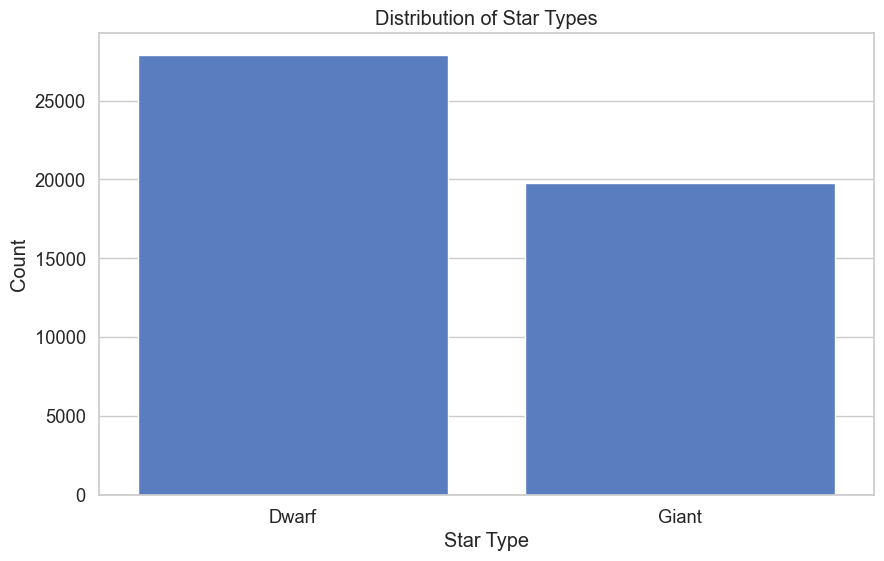

In [54]:
# Countplot for Star Types
sns.countplot(data=raw_cleaned_no_outliers, x='Star_Type', order=['Dwarf', 'Giant'])
plt.title('Distribution of Star Types')
plt.xlabel('Star Type')
plt.ylabel('Count')
plt.show()


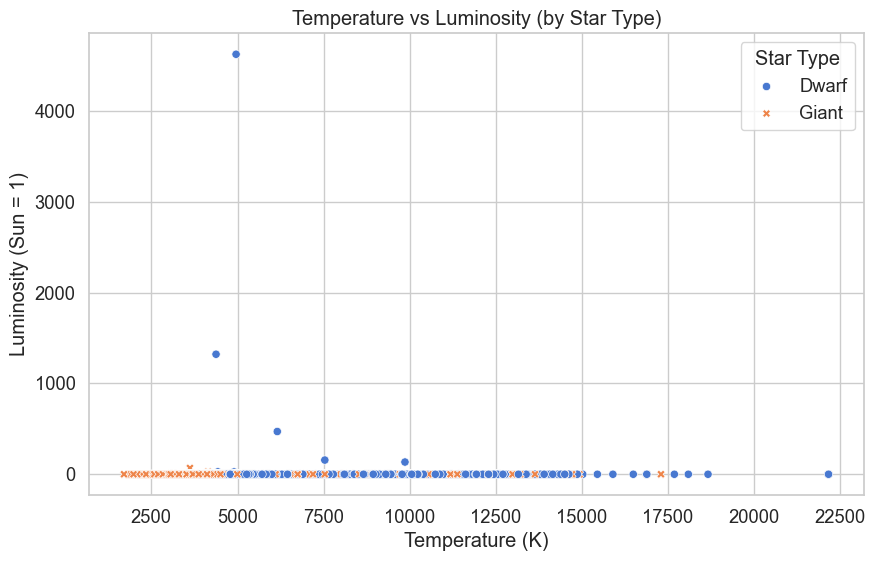

In [55]:
# Scatter plot for Temperature vs Luminosity
sns.scatterplot(data=raw_cleaned_no_outliers, x='Temperature_K', y='Luminosity_Sun', hue='Star_Type', style='Star_Type')
plt.title('Temperature vs Luminosity (by Star Type)')
plt.xlabel('Temperature (K)')
plt.ylabel('Luminosity (Sun = 1)')
plt.legend(title='Star Type')
plt.show()


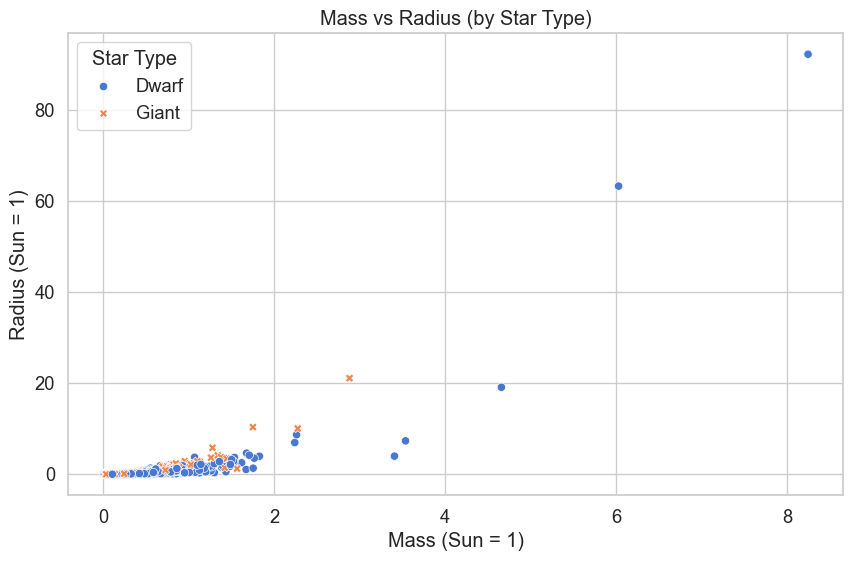

In [56]:
# Scatter plot for Mass vs Radius
sns.scatterplot(data=raw_cleaned_no_outliers, x='Mass_Sun', y='Radius_Sun', hue='Star_Type', style='Star_Type')
plt.title('Mass vs Radius (by Star Type)')
plt.xlabel('Mass (Sun = 1)')
plt.ylabel('Radius (Sun = 1)')
plt.legend(title='Star Type')
plt.show()


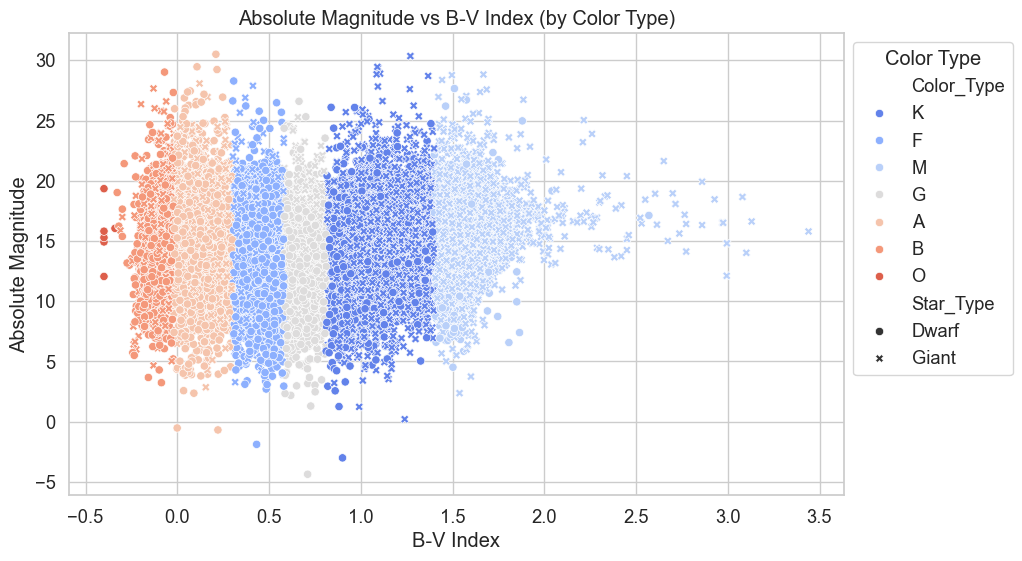

In [57]:
# Scatter plot for Absolute Magnitude vs B-V Index
sns.scatterplot(data=raw_cleaned_no_outliers, x='B-V', y='Amag', hue='Color_Type', palette='coolwarm', style='Star_Type')
plt.title('Absolute Magnitude vs B-V Index (by Color Type)')
plt.xlabel('B-V Index')
plt.ylabel('Absolute Magnitude')
plt.legend(title='Color Type', bbox_to_anchor=(1, 1))
plt.show()


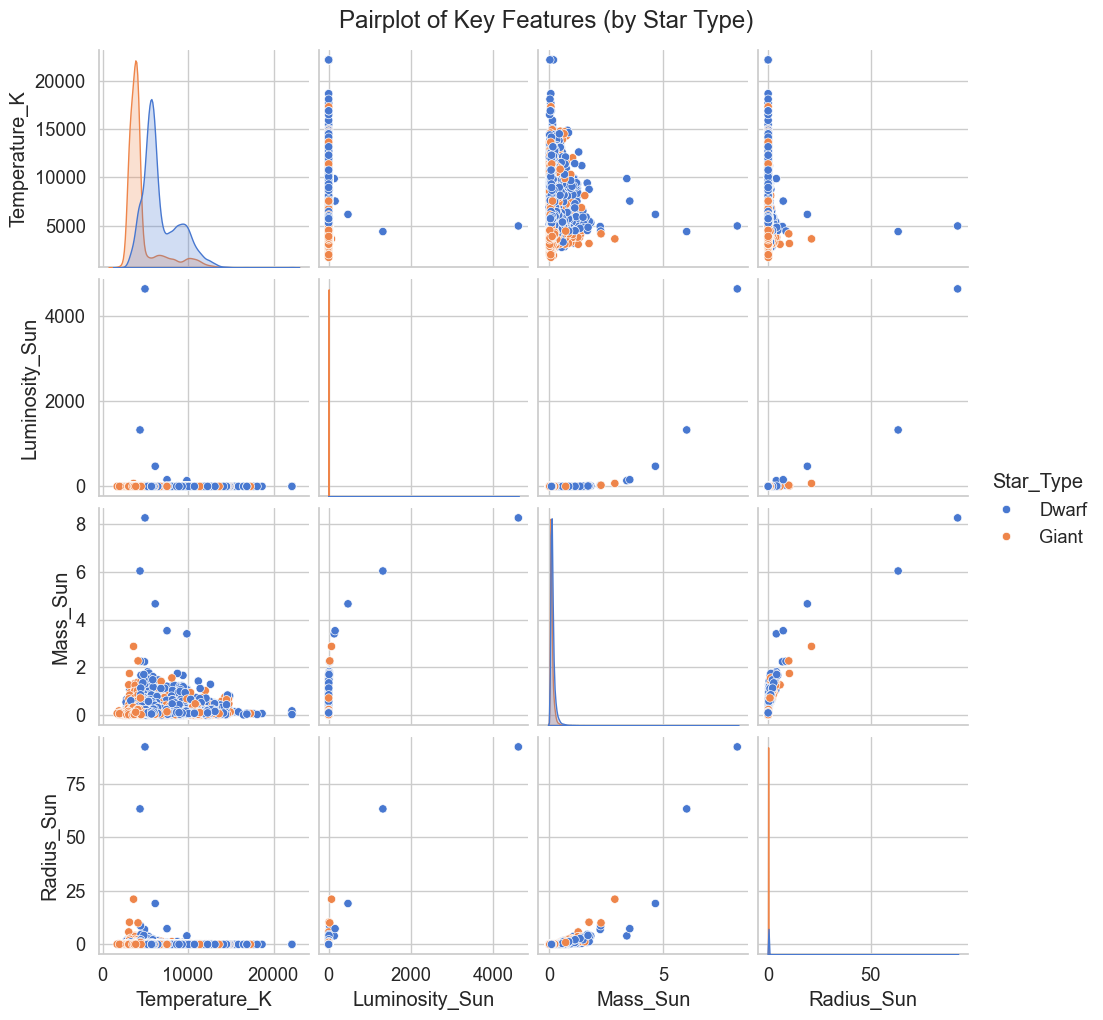

In [58]:
# Pairplot for important features
sns.pairplot(raw_cleaned_no_outliers, vars=['Temperature_K', 'Luminosity_Sun', 'Mass_Sun', 'Radius_Sun'], hue='Star_Type')
plt.suptitle('Pairplot of Key Features (by Star Type)', y=1.02)
plt.show()


In [61]:
# Identifying non-numeric values in numeric columns
non_numeric_rows = raw_cleaned_no_outliers.apply(lambda col: pd.to_numeric(col, errors='coerce').isna().sum())
print("Non-numeric values count in each column:")
print(non_numeric_rows[non_numeric_rows > 0])


Non-numeric values count in each column:
Plx                  42
e_Plx                42
B-V                 111
SpType            47673
Plx_arcsec           42
Distance_pc          42
Distance_ly          42
Amag               1310
Temperature_K       111
Luminosity_Sun     1310
Mass_Sun           1310
Radius_Sun         1401
Star_Type         47673
Color_Type        47673
dtype: int64


In [62]:
# Convert relevant columns to numeric and handle errors by replacing with NaN
columns_to_convert = ['Plx', 'e_Plx', 'B-V', 'Amag', 'Temperature_K', 'Luminosity_Sun', 'Mass_Sun', 'Radius_Sun']
raw_cleaned_no_outliers[columns_to_convert] = raw_cleaned_no_outliers[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Drop rows where essential columns have NaN after conversion
raw_cleaned_no_outliers = raw_cleaned_no_outliers.dropna(subset=['Plx', 'B-V', 'Temperature_K']).reset_index(drop=True)
print(f"Shape after dropping rows with NaN in essential columns: {raw_cleaned_no_outliers.shape}")


Shape after dropping rows with NaN in essential columns: (47528, 17)


In [63]:
# Fill missing spectral types with a placeholder value
raw_cleaned_no_outliers['SpType'].fillna('Unknown', inplace=True)


In [64]:
# Reclassify star types using the classify_star_type function
raw_cleaned_no_outliers['Star_Type'] = raw_cleaned_no_outliers['SpType'].apply(classify_star_type)

# Drop rows where star type couldn't be determined
raw_cleaned_no_outliers = raw_cleaned_no_outliers.query('Star_Type != "Other"').reset_index(drop=True)
print(f"Shape after regenerating star type and dropping 'Other': {raw_cleaned_no_outliers.shape}")


Shape after regenerating star type and dropping 'Other': (47528, 17)


In [65]:
# Regenerate Color_Type based on clean B-V values
raw_cleaned_no_outliers['Color_Type'] = raw_cleaned_no_outliers['B-V'].apply(classify_color_type)


In [66]:
# Check remaining NaN values in dataset
remaining_nans = raw_cleaned_no_outliers.isnull().sum()
print("Remaining NaN values after cleaning:")
print(remaining_nans[remaining_nans > 0])

# Drop rows with NaN in derived columns (if any)
raw_cleaned_no_outliers.dropna(inplace=True)
print(f"Final shape after dropping remaining NaN values: {raw_cleaned_no_outliers.shape}")


Remaining NaN values after cleaning:
Amag              1256
Luminosity_Sun    1256
Mass_Sun          1256
Radius_Sun        1256
dtype: int64
Final shape after dropping remaining NaN values: (46272, 17)


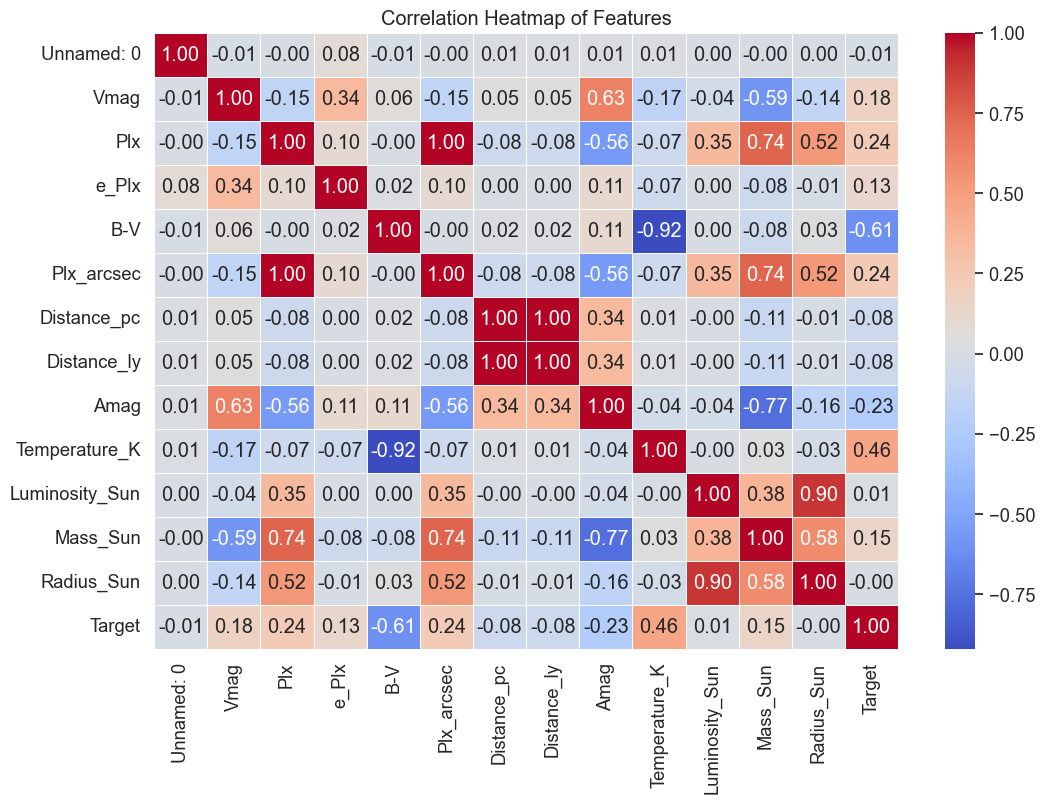

In [68]:
# Select only numeric columns for correlation
numeric_columns = raw_cleaned_no_outliers.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
corr_matrix = numeric_columns.corr().round(2)

# Plotting heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='0.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()


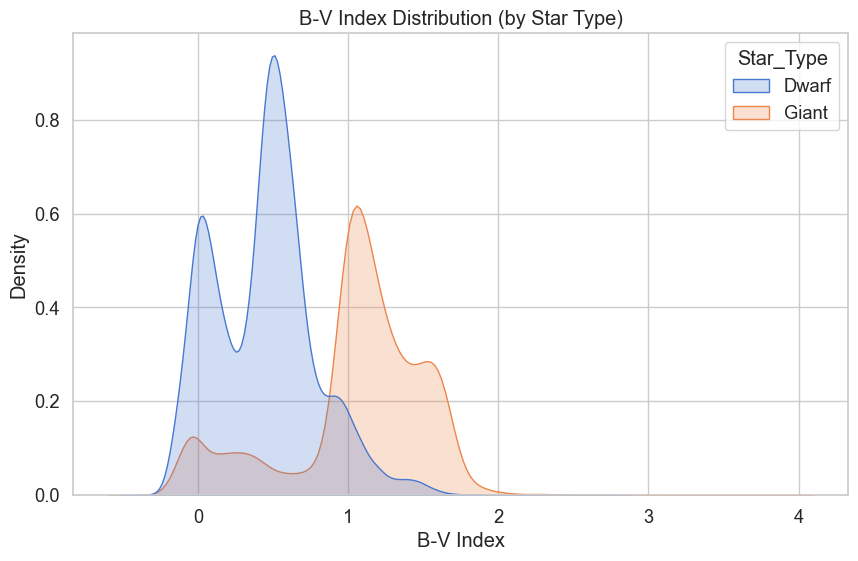

In [60]:
# KDE plot for B-V Index by Star Type
sns.kdeplot(data=raw_cleaned_no_outliers, x='B-V', hue='Star_Type', fill=True)
plt.title('B-V Index Distribution (by Star Type)')
plt.xlabel('B-V Index')
plt.ylabel('Density')
plt.show()


In [69]:
# Dropping features with high multicollinearity (> 0.9 correlation)
# Luminosity, Mass, Radius are highly correlated—let’s retain one representative feature
raw_cleaned_no_outliers.drop(['Luminosity_Sun', 'Radius_Sun'], axis=1, inplace=True)

# Dropping 'Distance_pc' as 'Distance_ly' conveys the same information in a more interpretable unit
raw_cleaned_no_outliers.drop('Distance_pc', axis=1, inplace=True)


In [70]:
# Applying log transformation to skewed features
skewed_features = ['Distance_ly', 'Temperature_K', 'Mass_Sun']

for feature in skewed_features:
    raw_cleaned_no_outliers[f'log_{feature}'] = np.log1p(raw_cleaned_no_outliers[feature])


In [81]:
# Replace zero parallax values with a small positive constant to avoid division by zero
epsilon = 1e-6  # Small positive constant
raw_cleaned_no_outliers['Plx_arcsec'] = raw_cleaned_no_outliers['Plx'].replace(0, epsilon) * 0.001

# Recalculate distance
raw_cleaned_no_outliers['Distance_ly'] = 1 / raw_cleaned_no_outliers['Plx_arcsec'] * 3.26


In [82]:
# Recalculate log-transformed features after fixing zero parallax
raw_cleaned_no_outliers['log_Distance_ly'] = np.log1p(raw_cleaned_no_outliers['Distance_ly'])


In [83]:
# Check and remove rows with inf or NaN values if they still exist
raw_cleaned_no_outliers.replace([np.inf, -np.inf], np.nan, inplace=True)
raw_cleaned_no_outliers.dropna(inplace=True)

print(f"Shape after removing inf and NaN values: {raw_cleaned_no_outliers.shape}")


Shape after removing inf and NaN values: (46255, 17)


In [84]:
# One-hot encoding for 'Color_Type'
encoded_df = pd.get_dummies(raw_cleaned_no_outliers, columns=['Color_Type'], drop_first=True)


In [85]:
# Dropping non-numeric columns that won't be used in the model
final_df = encoded_df.drop(['SpType', 'Star_Type'], axis=1)

# Display final dataframe info
final_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 46255 entries, 0 to 47526
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         46255 non-null  int64  
 1   Vmag               46255 non-null  float64
 2   Plx                46255 non-null  float64
 3   e_Plx              46255 non-null  float64
 4   B-V                46255 non-null  float64
 5   Plx_arcsec         46255 non-null  float64
 6   Distance_ly        46255 non-null  float64
 7   Amag               46255 non-null  float64
 8   Temperature_K      46255 non-null  float64
 9   Mass_Sun           46255 non-null  float64
 10  Target             46255 non-null  int64  
 11  log_Distance_ly    46255 non-null  float64
 12  log_Temperature_K  46255 non-null  float64
 13  log_Mass_Sun       46255 non-null  float64
 14  Color_Type_B       46255 non-null  bool   
 15  Color_Type_F       46255 non-null  bool   
 16  Color_Type_G       46255 no

In [86]:
# Check for NaN or Inf values in the final dataframe
if final_df.isnull().sum().sum() > 0 or np.isinf(final_df).sum().sum() > 0:
    print("Warning: There are NaN or Inf values in the dataset!")
    print(final_df.describe().T)
else:
    print("No NaN or Inf values detected.")


No NaN or Inf values detected.


In [87]:
from sklearn.model_selection import train_test_split

# Defining features and target
X = final_df.drop('Target', axis=1)
y = final_df['Target']

# Splitting data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [88]:
from sklearn.preprocessing import StandardScaler

# Standardizing features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# List of models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}


In [91]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Function to train and evaluate models
def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        results.append((name, acc, precision, recall, f1))
    
    # Creating a dataframe to display results
    results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
    results_df.sort_values(by='F1 Score', ascending=False, inplace=True)
    
    return results_df

# Evaluate models and display results
model_results = evaluate_models(models, X_train_scaled, y_train, X_test_scaled, y_test)
model_results


[LightGBM] [Info] Number of positive: 21872, number of negative: 15132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3330
[LightGBM] [Info] Number of data points in the train set: 37004, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.591071 -> initscore=0.368396
[LightGBM] [Info] Start training from score 0.368396


,Model,Accuracy,Precision,Recall,F1 Score
6,Gradient Boosting,0.891363,0.894188,0.925750,0.909695
8,LightGBM,0.890715,0.896178,0.921909,0.908861
9,CatBoost,0.890606,0.896018,0.921909,0.908780
0,Logistic Regression,0.889958,0.896331,0.920263,0.908139
7,XGBoost,0.888228,0.895187,0.918435,0.906662
5,AdaBoost,0.886283,0.888049,0.924104,0.905718
4,Support Vector Machine,0.885850,0.888654,0.922458,0.905240
2,Random Forest,0.884445,0.889775,0.918252,0.903789
3,K-Nearest Neighbors,0.878500,0.887442,0.909839,0.898501
1,Decision Tree,0.822289,0.845625,0.855523,0.850545


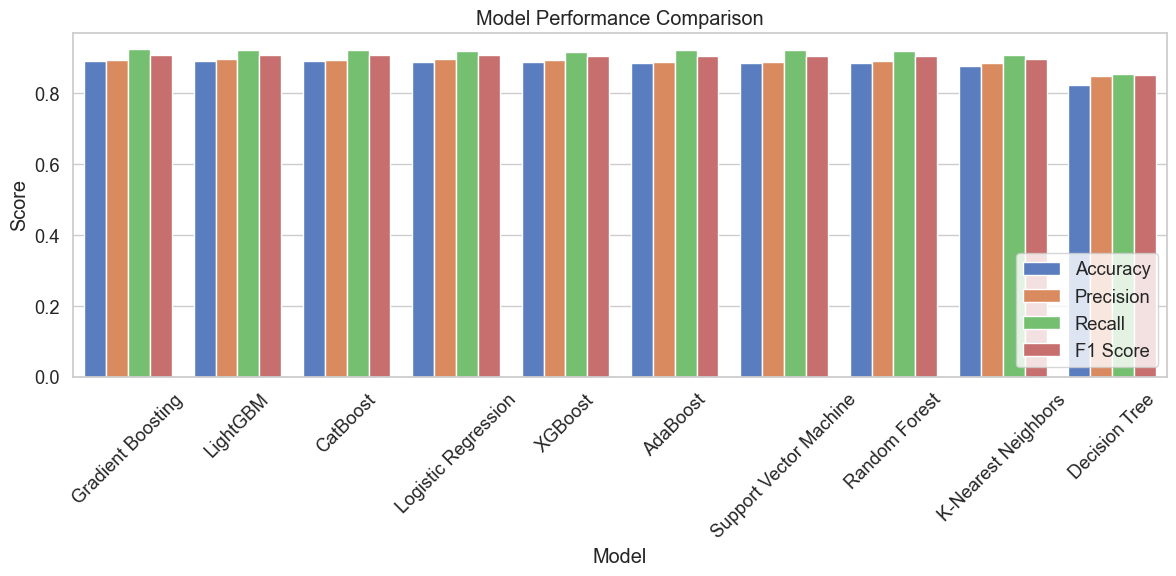

In [93]:
# Plotting model performance
plt.figure(figsize=(12, 6))
sns.barplot(data=model_results.melt(id_vars='Model', var_name='Metric', value_name='Score'),
            x='Model', y='Score', hue='Metric')
plt.xticks(rotation=45)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [94]:
from sklearn.model_selection import GridSearchCV

# Defining parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initializing GridSearchCV
rf_grid_search = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42),
                              param_grid=rf_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

# Running Grid Search
rf_grid_search.fit(X_train_scaled, y_train)

# Best parameters and best score
print(f"Best Parameters for Random Forest: {rf_grid_search.best_params_}")
print(f"Best F1 Score: {rf_grid_search.best_score_:.4f}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best F1 Score: 0.9109


In [95]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Defining parameter distribution for XGBoost
xgb_param_dist = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.5, 1.0),
    'colsample_bytree': uniform(0.5, 1.0)
}

# Initializing RandomizedSearchCV
xgb_random_search = RandomizedSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                                       param_distributions=xgb_param_dist, n_iter=50, cv=5, scoring='f1', n_jobs=-1, verbose=1)

# Running Random Search
xgb_random_search.fit(X_train_scaled, y_train)

# Best parameters and best score
print(f"Best Parameters for XGBoost: {xgb_random_search.best_params_}")
print(f"Best F1 Score: {xgb_random_search.best_score_:.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/shubhupadhyay/miniconda3/envs/stock_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:42:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1733179641447/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/shubhupadhyay/miniconda3/envs/stock_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:42:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1733179641447/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/shubhupadhyay/miniconda3/envs/stock_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:42:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1733179641447/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/shubhupadhyay/miniconda3/envs/stock_env/lib/python3.10/site-packages/xgboost/c

Best Parameters for XGBoost: {'colsample_bytree': 0.920898827934147, 'learning_rate': 0.01682419082414466, 'max_depth': 7, 'n_estimators': 350, 'subsample': 0.9610352483939046}
Best F1 Score: 0.9116


In [96]:
# Defining parameter grid for LightGBM
lgbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_samples': [10, 20, 30]
}

# Initializing GridSearchCV
lgbm_grid_search = GridSearchCV(LGBMClassifier(random_state=42),
                                param_grid=lgbm_param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

# Running Grid Search
lgbm_grid_search.fit(X_train_scaled, y_train)

# Best parameters and best score
print(f"Best Parameters for LightGBM: {lgbm_grid_search.best_params_}")
print(f"Best F1 Score: {lgbm_grid_search.best_score_:.4f}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Info] Number of positive: 17497, number of negative: 12106
[LightGBM] [Info] Number of positive: 17498, number of negative: 12106
[LightGBM] [Info] Number of positive: 17498, number of negative: 12105
[LightGBM] [Info] Number of positive: 17497, number of negative: 12106
[LightGBM] [Info] Number of positive: 17498, number of negative: 12105
[LightGBM] [Info] Number of positive: 17497, number of negative: 12106
[LightGBM] [Info] Number of positive: 17498, number of negative: 12105
[LightGBM] [Info] Number of positive: 17498, number of negative: 12105
[LightGBM] [Info] Number of positive: 17498, number of negative: 12106
[LightGBM] [Info] Number of positive: 17497, number of negative: 12106
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3330
[LightGBM] [Info] Auto-choosing 

In [97]:
# Selecting the best model based on tuning results
final_model = lgbm_grid_search.best_estimator_

# Predicting on test set
y_pred_final = final_model.predict(X_test_scaled)

# Evaluating final model performance
final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)

print(f"Final Model Performance on Test Set:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1 Score: {final_f1:.4f}")


Final Model Performance on Test Set:
Accuracy: 0.8902
Precision: 0.8948
Recall: 0.9226
F1 Score: 0.9085


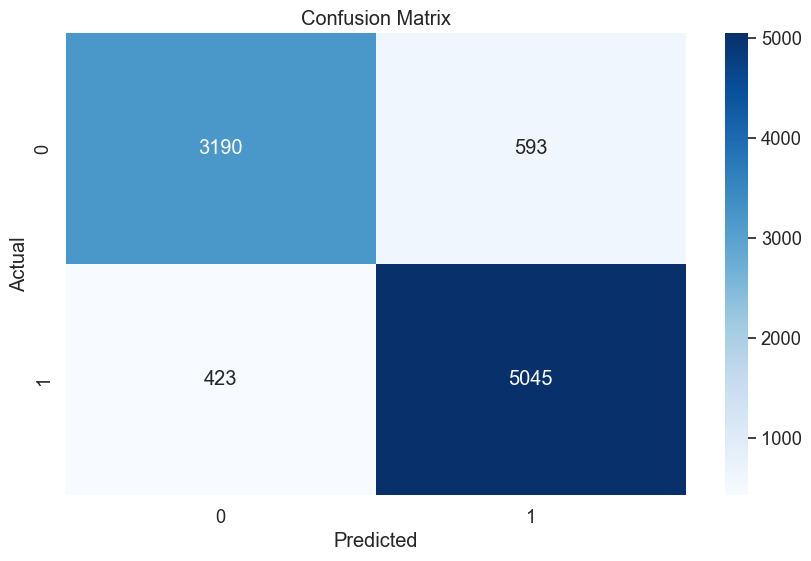

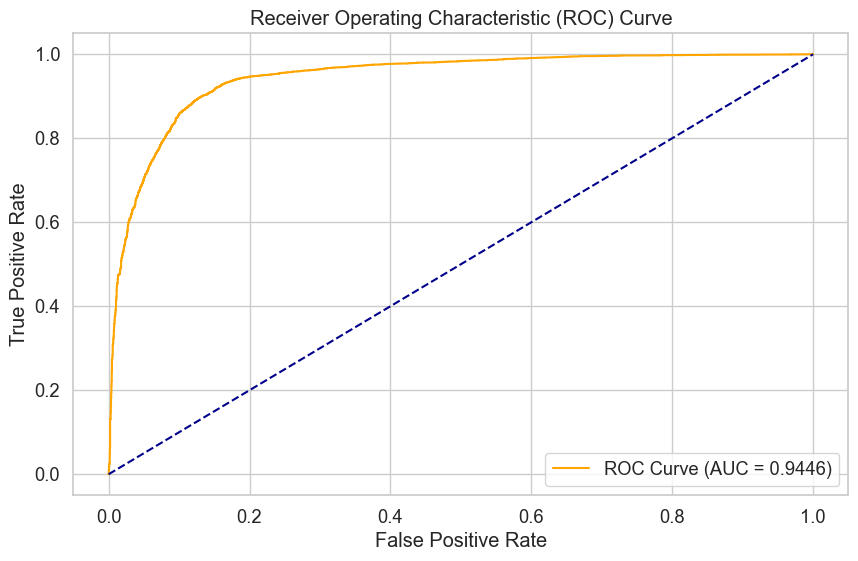

In [98]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC curve
y_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='orange', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [99]:
# Predicting again to get misclassified samples
y_pred_final = final_model.predict(X_test_scaled)

# Identifying indices of misclassified samples
misclassified_indices = np.where(y_pred_final != y_test)[0]

# Extracting misclassified samples
misclassified_samples = X_test.iloc[misclassified_indices]
misclassified_labels = y_test.iloc[misclassified_indices]
predicted_labels = y_pred_final[misclassified_indices]

# Creating a DataFrame to display actual vs predicted labels
error_analysis_df = misclassified_samples.copy()
error_analysis_df['Actual'] = misclassified_labels.values
error_analysis_df['Predicted'] = predicted_labels

print("Misclassified Samples (Actual vs Predicted):")
error_analysis_df.head()


Misclassified Samples (Actual vs Predicted):


,Unnamed: 0,Vmag,Plx,e_Plx,B-V,Plx_arcsec,Distance_ly,Amag,Temperature_K,Mass_Sun,...,log_Temperature_K,log_Mass_Sun,Color_Type_B,Color_Type_F,Color_Type_G,Color_Type_K,Color_Type_M,Color_Type_O,Actual,Predicted
13402,29288,6.93,1.18,1.01,-0.004,0.00118,2762.711864,16.570590,9902.234637,0.066518,...,9.200617,0.064399,False,False,False,False,False,False,0,1
29568,62501,7.22,0.80,0.97,0.005,0.00080,4075.000000,17.704550,9779.310345,0.051232,...,9.188126,0.049963,False,False,False,False,False,False,1,0
23356,50071,6.05,8.39,1.05,0.844,0.00839,388.557807,11.431190,4533.248082,0.217211,...,8.419415,0.196562,False,False,False,True,False,False,1,0
6825,14661,8.97,1.33,1.53,1.363,0.00133,2451.127820,18.350742,3403.744599,0.044150,...,8.132925,0.043203,False,False,False,True,False,False,1,0
47510,99945,8.30,6.30,1.63,0.700,0.00630,517.460317,14.303297,4992.957746,0.112117,...,8.515984,0.106265,False,False,True,False,False,False,0,1


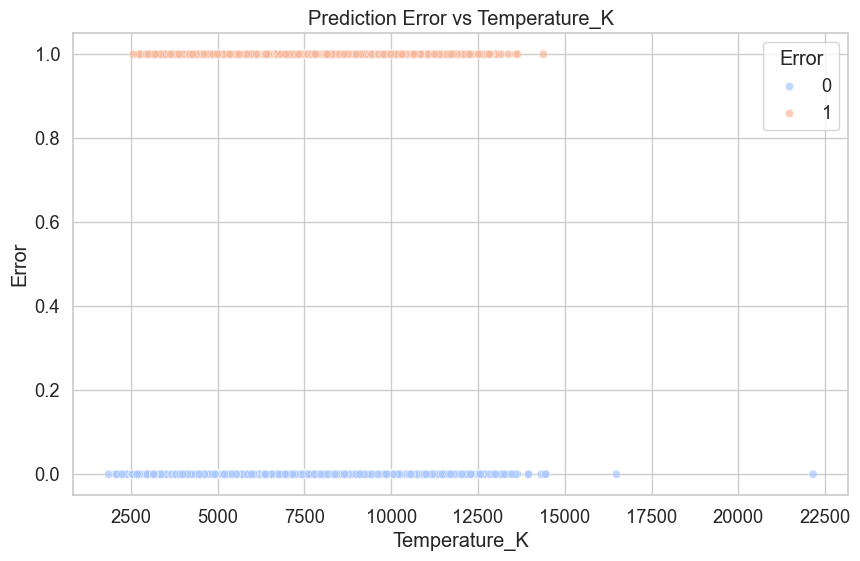

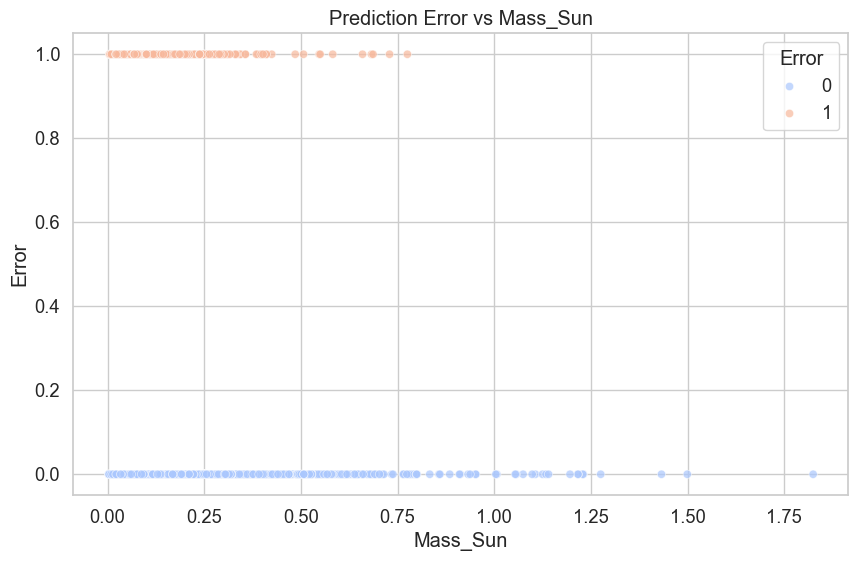

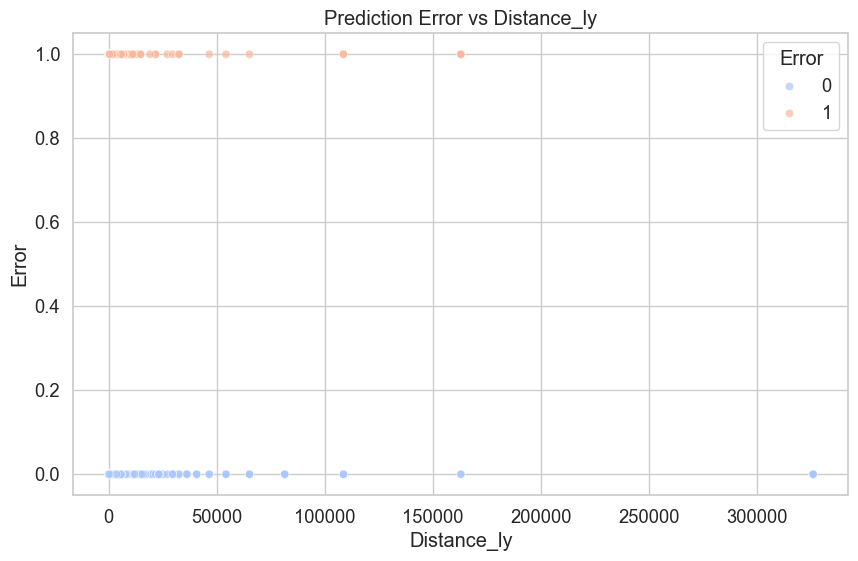

In [100]:
# Adding prediction errors to X_test for analysis
X_test_with_error = X_test.copy()
X_test_with_error['Error'] = np.abs(y_test - y_pred_final)

# Plotting error vs key features
for feature in ['Temperature_K', 'Mass_Sun', 'Distance_ly']:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=X_test_with_error, x=feature, y='Error', hue='Error', palette='coolwarm', alpha=0.7)
    plt.title(f'Prediction Error vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Error')
    plt.legend(title='Error')
    plt.show()


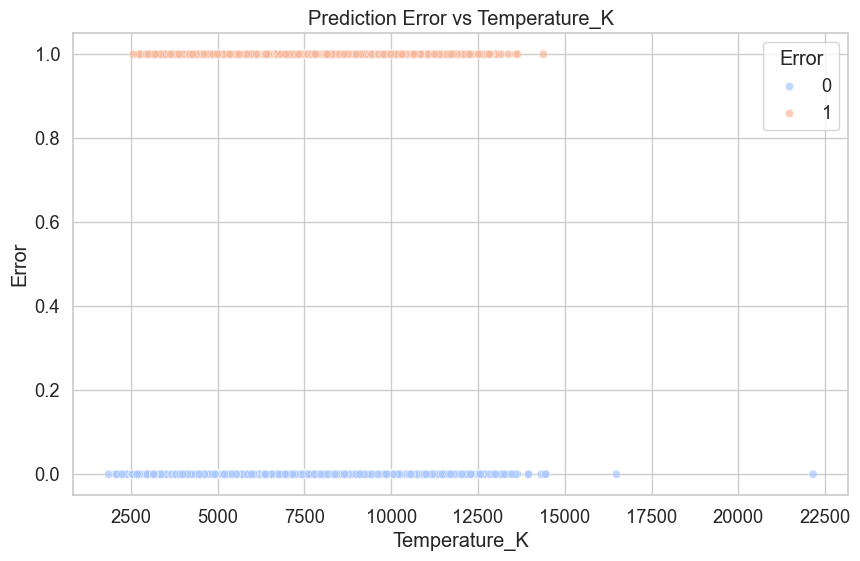

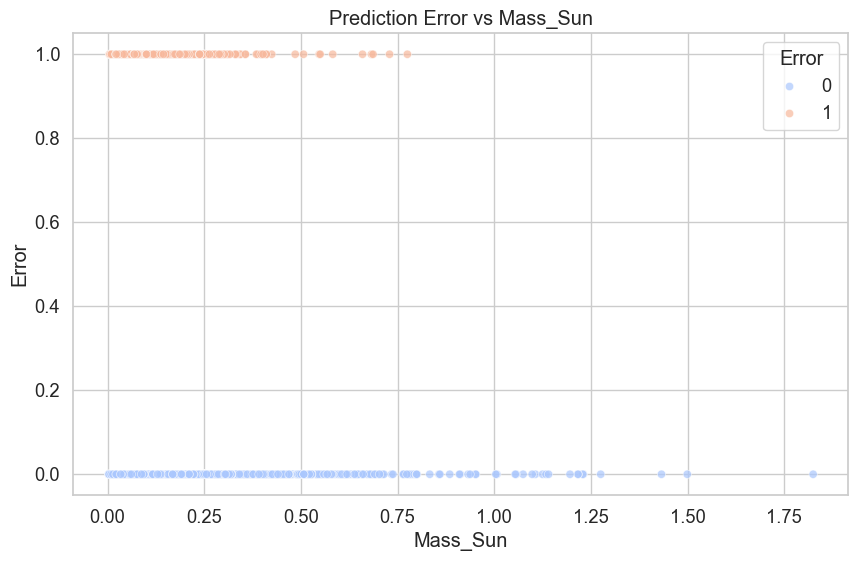

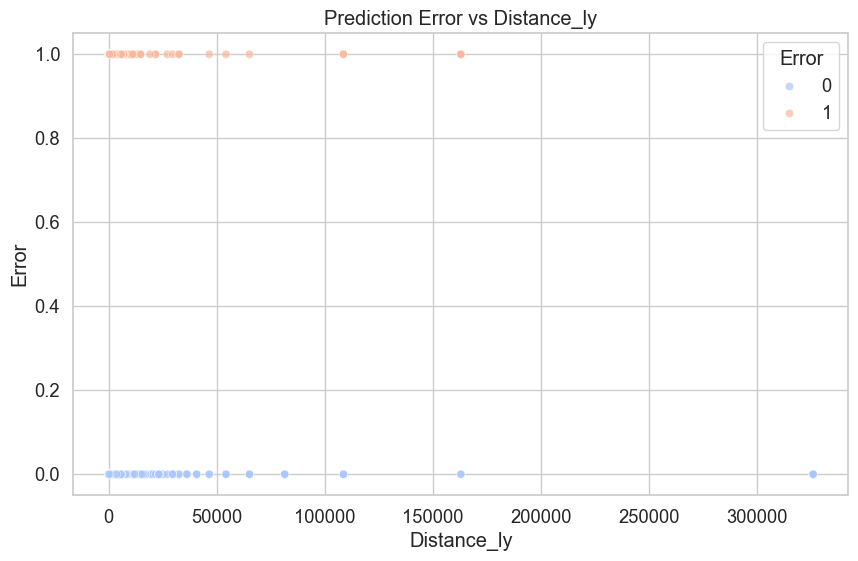

In [101]:
# Adding prediction errors to X_test for analysis
X_test_with_error = X_test.copy()
X_test_with_error['Error'] = np.abs(y_test - y_pred_final)

# Plotting error vs key features
for feature in ['Temperature_K', 'Mass_Sun', 'Distance_ly']:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=X_test_with_error, x=feature, y='Error', hue='Error', palette='coolwarm', alpha=0.7)
    plt.title(f'Prediction Error vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Error')
    plt.legend(title='Error')
    plt.show()


 98%|===================| 9021/9251 [00:34<00:00]        

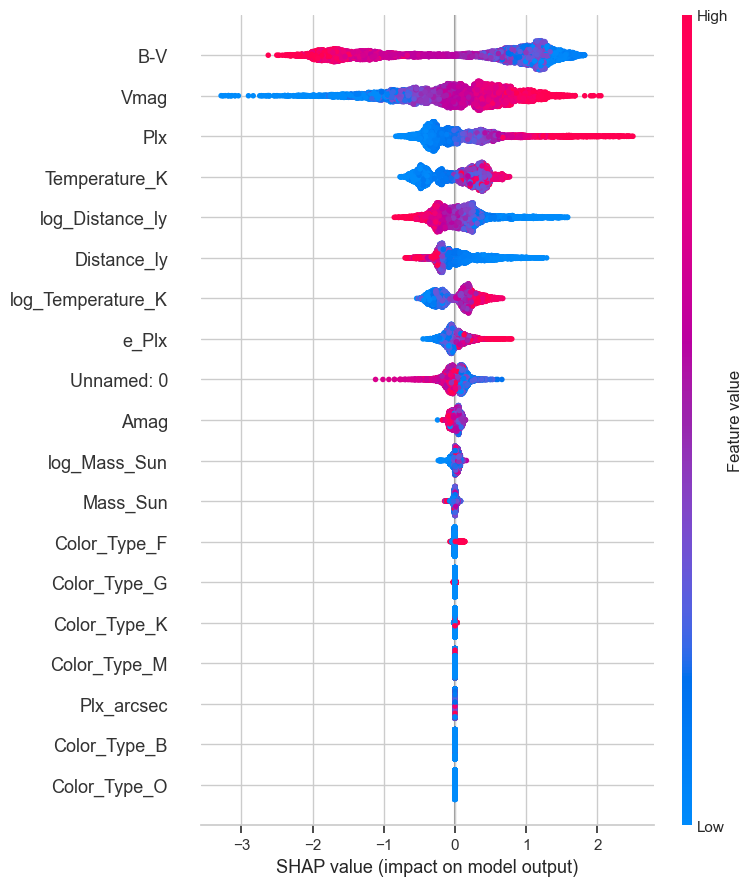

In [102]:
import shap

# Initialize SHAP explainer for the final model
explainer = shap.Explainer(final_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

# Displaying SHAP summary plot for global feature importance
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)


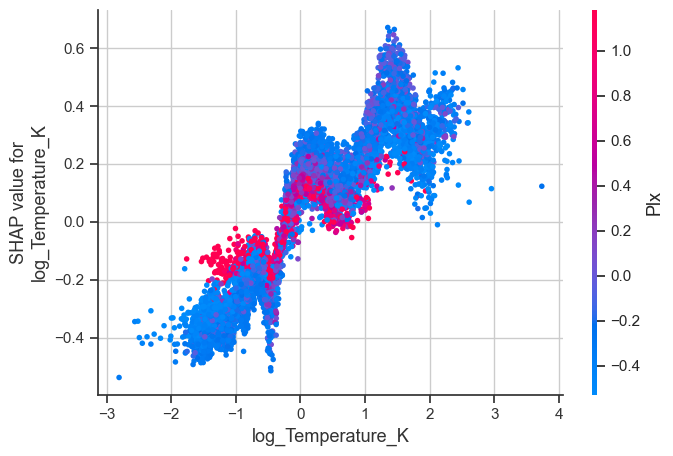

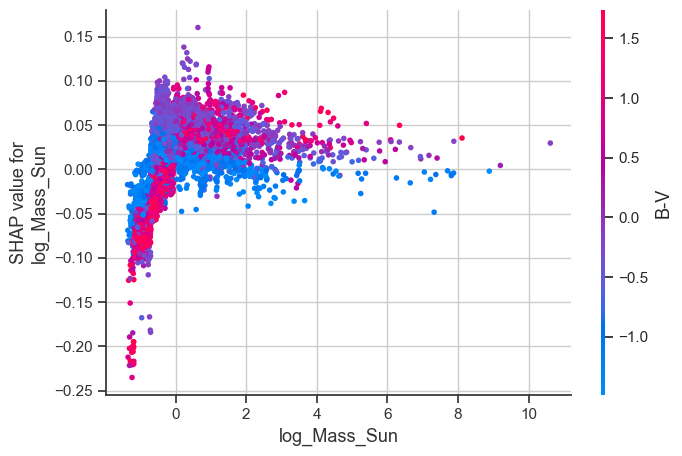

In [103]:
# SHAP dependence plot for 'log_Temperature_K'
shap.dependence_plot('log_Temperature_K', shap_values.values, X_test_scaled, feature_names=X.columns)

# SHAP dependence plot for 'log_Mass_Sun'
shap.dependence_plot('log_Mass_Sun', shap_values.values, X_test_scaled, feature_names=X.columns)
